## Encoder Only Architecture

### What Is an Encoder-Only Transformer?

An encoder-only transformer processes input sequences to produce rich, contextualized representations. It’s designed for understanding tasks—not generation.

🔹 **Key Characteristics:**
- Uses self-attention to model relationships between all tokens in the input.
- Processes the entire input bidirectionally (unlike decoder-only models which are autoregressive).
- Outputs a contextual embedding for each token.

🔹 **Famous Models:**
- BERT (Bidirectional Encoder Representations from Transformers)
- RoBERTa
- DistilBERT
- ALBERT


![Encoder only](transformer-architectures.png)

#### ⚙️ Architecture Breakdown

1. **Input Embeddings**
Each token is embedded using:
- Token embeddings (from a vocabulary)
- Positional embeddings (to encode order)
- Segment embeddings (for sentence pairs)
  
2. **Multi-Head Self-Attention**
Each token attends to every other token in the sequence:
- Captures dependencies regardless of distance
- Bidirectional: looks both left and right
  
3. **Feed-Forward Network**
Each token’s representation is passed through a fully connected network:
- Applies non-linearity and transformation
- Shared across all positions
  
4. **Layer Normalization + Residual Connections**
Stabilizes training and helps gradient flow.

✅ **Advantages**
| Advantage | Description | 
|----------|-------------|
| 🧠 Deep Understanding | Captures rich contextual info from both directions | 
| 🔍 Great for Classification | Ideal for tasks like sentiment analysis, NER, QA (extractive) | 
| 🧩 Modular | Can be used as a feature extractor for downstream tasks | 
| 🏋️‍♂️ Pretrained Models | Many pretrained models available (BERT, RoBERTa, etc.) | 



❌ **Disadvantages**
| Disadvantage | Description | 
|---------------|--------------|
| 🚫 Not Generative | Cannot generate text (no decoder) | 
| 🐘 Memory Intensive | Self-attention scales quadratically with sequence length | 
| 🧱 Fixed Input Length | Limited by max token length (e.g., 512 for BERT) | 
| 🔄 No Autoregression | Not suitable for tasks like text completion or summarization | 




🧪 **Python Code: Using BERT for Sentence Embeddings**

Let’s use Hugging Face Transformers to extract embeddings from BERT.

In [3]:

from transformers import BertTokenizer, BertModel
import torch
from tqdm import tqdm


# Load pre-trained BERT model and tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')

# Input sentence
sentence = "Transformers are powerful models for NLP tasks."

# Tokenize and convert to tensor
inputs = tokenizer(sentence, return_tensors='pt')

# Get hidden states from BERT
with torch.no_grad():
    outputs = model(**inputs)
    last_hidden_state = outputs.last_hidden_state  # shape: [1, seq_len, 768]

# Mean pooling to get sentence embedding
attention_mask = inputs['attention_mask']
mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size())
sum_embeddings = torch.sum(last_hidden_state * mask_expanded, 1)
sum_mask = torch.clamp(mask_expanded.sum(1), min=1e-9)
sentence_embedding = sum_embeddings / sum_mask

print("Sentence embedding shape:", sentence_embedding.shape)


Sentence embedding shape: torch.Size([1, 768])


**Another example for text classification**

We'll fine-tune BERT to classify sentences into categories (e.g., positive/negative sentiment).

In [6]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from datasets import load_dataset
import torch
from tqdm import tqdm

# Load dataset (binary sentiment classification)
dataset = load_dataset("imdb", split="train[:2000]").train_test_split(test_size=0.2)

# Load tokenizer and tokenize dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(example):
    return tokenizer(example["text"], padding="max_length", truncation=True)

tokenized_dataset = dataset.map(tokenize_function, batched=True)
tokenized_dataset.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Load model
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)

# Training setup
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=2,
    logging_dir="./logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
)

# Train the model
trainer.train()

Map: 100%|████████████████████████████████████████████████████████████████████| 400/400 [00:00<00:00, 591.44 examples/s]
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss
1,No log,0.000075
2,No log,0.000053


TrainOutput(global_step=400, training_loss=0.007759683132171631, metrics={'train_runtime': 76.3164, 'train_samples_per_second': 41.931, 'train_steps_per_second': 5.241, 'total_flos': 841955377152000.0, 'train_loss': 0.007759683132171631, 'epoch': 2.0})

**Visualizing Sentence Classification Prediction**

In [7]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch
import torch.nn.functional as F

# Load model and tokenizer
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
model.eval()

# Sample sentence
sentence = "The movie was absolutely fantastic!"

# Tokenize
inputs = tokenizer(sentence, return_tensors="pt")

# Predict
with torch.no_grad():
    logits = model(**inputs).logits
    probs = F.softmax(logits, dim=-1)
    predicted_class = torch.argmax(probs).item()

# Label mapping
label_map = {0: "Negative", 1: "Positive"}

# Print result
print(f"Sentence: {sentence}")
print(f"Predicted Sentiment: {label_map[predicted_class]} (Confidence: {probs[0][predicted_class]:.2f})")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Sentence: The movie was absolutely fantastic!
Predicted Sentiment: Negative (Confidence: 0.60)


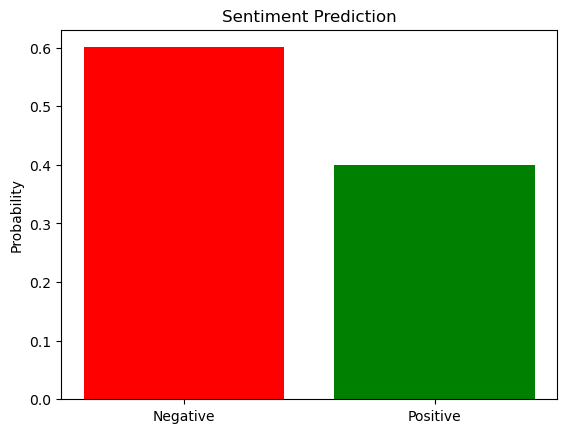

In [8]:
import matplotlib.pyplot as plt

labels = ["Negative", "Positive"]
plt.bar(labels, probs[0].numpy(), color=["red", "green"])
plt.title("Sentiment Prediction")
plt.ylabel("Probability")
plt.show()

**Another example for NER using Encoder Only BERT Model**

NER is a token classification task—each token is labeled (e.g., PER, LOC, ORG).

🧾 Example using the CoNLL-2003 dataset

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from termcolor import colored

from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    Trainer,
    TrainingArguments,
)
from datasets import load_dataset
import evaluate

# 1) Load CoNLL-2003 NER dataset
raw_datasets = load_dataset("conll2003")

# 2) Prepare tokenizer & label maps
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

label_list = raw_datasets["train"].features["ner_tags"].feature.names
id2label = {i: lab for i, lab in enumerate(label_list)}
label2id = {lab: i for i, lab in id2label.items()}

# 3) Tokenize + align labels
def tokenize_and_align_labels(examples):
    # Tokenize input tokens (batch)
    tokenized_inputs = tokenizer(
        examples["tokens"],
        is_split_into_words=True,
        truncation=True,
        padding="max_length",
        max_length=128,
    )

    all_labels = []
    for i, word_labels in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                # Special/token padding
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                # First token of a word
                label_ids.append(word_labels[word_idx])
            else:
                # Subsequent subword tokens
                label_ids.append(-100)
            previous_word_idx = word_idx

        all_labels.append(label_ids)

    tokenized_inputs["labels"] = all_labels
    return tokenized_inputs

tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)
tokenized_datasets.set_format("torch")

# 4) Load model with label mappings
model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_list),
    id2label=id2label,
    label2id=label2id,
)

# 5) Prepare seqeval metric
seqeval = evaluate.load("seqeval")

def compute_metrics(p):
    logits, labels = p
    preds = np.argmax(logits, axis=-1)

    # Remove ignored index (-100) and convert IDs to labels
    true_labels = [
        [id2label[l] for l in lab_seq if l != -100]
        for lab_seq in labels
    ]
    pred_labels = [
        [id2label[p_] for (p_, l_) in zip(pred_seq, lab_seq) if l_ != -100]
        for pred_seq, lab_seq in zip(preds, labels)
    ]

    results = seqeval.compute(predictions=pred_labels, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall":    results["overall_recall"],
        "f1":        results["overall_f1"],
        "accuracy":  results["overall_accuracy"],
    }

# 6) Training arguments & Trainer
training_args = TrainingArguments(
    output_dir="./ner_results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=3,
    logging_dir="./ner_logs",
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=compute_metrics,
)

# 7) Train & evaluate
trainer.train()


Map: 100%|█████████████████████████████████████████████████████████████████| 3453/3453 [00:00<00:00, 8242.28 examples/s]
Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.051700,0.047736,0.915919,0.928571,0.922202,0.987160
2,0.020100,0.048114,0.941900,0.942217,0.942058,0.989985
3,0.010100,0.041749,0.947766,0.950640,0.949201,0.991368


KeyError: 'precision'

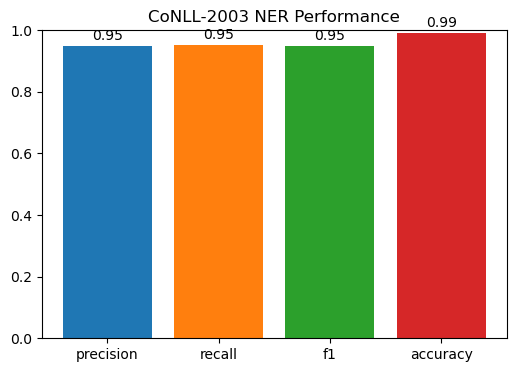

In [19]:
metrics = trainer.evaluate()

# Build a mapping from short name → eval_key
metric_names = ["precision", "recall", "f1", "accuracy"]
eval_keys    = [f"eval_{m}" for m in metric_names]
values       = [metrics[k] for k in eval_keys]

# Now you can plot
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 4))
bars = plt.bar(metric_names, values, color=["C0","C1","C2","C3"])
plt.ylim(0, 1.0)
plt.title("CoNLL-2003 NER Performance")

for bar, v in zip(bars, values):
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        v + 0.02,
        f"{v:.2f}",
        ha="center"
    )

plt.show()

🧠 Summary
| Task | Model Used | Output Type | 
|---------|------------|----------|
| Sentence Classification | BertForSequenceClassification | One label per sentence | 
| Named Entity Recognition | BertForTokenClassification | One label per token | 


Both tasks leverage the encoder-only architecture of BERT, but with different heads: one for sentence-level classification, and one for token-level tagging.
